In [234]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm

from collections import defaultdict
import itertools
import re

import time
import math

In [235]:
### You may import any Python's standard library here (Do not import other external libraries) ###
from numpy import linalg as LA
from collections import Counter
from itertools import combinations

In [236]:
pass_test_1 = False
pass_test_2 = False
pass_test_3 = False
pass_test_4 = False
pass_test_5 = False
pass_test_6 = False
pass_test_7 = False
pass_test_8 = False
pass_test_9 = False

## Implementing LSH algorithm

### 0. Dataset

#### 0.1 Import 20-news dataset

In [237]:
newsgroup_dataset = datasets.fetch_20newsgroups(data_home='./dataset/', subset='train', 
                                                remove=('headers', 'footers', 'quotes'), download_if_missing=True)

In [238]:
raw_documents = newsgroup_dataset['data']
len(raw_documents)

11314

In [239]:
raw_documents[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

#### 0.2 Preprocess the documents

In [240]:
K = 5

In [241]:
def preprocess(documents):
    processed_words = defaultdict(list)
    cnt = 0
    
    for doc in documents:
        # first, filter out some uncesseary symbols like punctuations
        doc = re.sub('\/|\-|\'|\@|\%|\$|\#|\,|\(|\)|\}|\"|\{|\?|\.|\!|\;|\:', '', doc)
        
        # second, split the document into the words
        for word in doc.split():
            
            # third, let word to be the lower-case
            if word.isalpha():
                processed_words[cnt].append(word.lower())
        
        # fourth, filter out the articles that has less than k words
        if len(processed_words[cnt]) < K:
            continue
        else:
            processed_words[cnt] = ' '.join(processed_words[cnt])
            cnt += 1

    return list(processed_words.values())

In [242]:
documents = preprocess(raw_documents)
del raw_documents
len(documents)

10882

In [243]:
documents[0]

'i was wondering if anyone out there could enlighten me on this car i saw the other day it was a sports car looked to be from the late early it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please email'

### 1. Shingling

In [244]:
########################################################################################################################
# Programming 1  [15pt]                                                                                                #
#  In this section, you will implement the shingling algorithm to convert the document into the characteristic matrix. #
#  However, since storing the whole characteristic matrix in the form of a dense matrix is expensivein terms of space, #
#    your implementation should store the characteristic matrix in the form of a dictionary.                           #
#                                                                                                                      #
#    i) get the all unique shingles from the documents [10pt]                                                          #
#   ii) create the dictionary that maps each document to the list of shingles and their counts [5pt]                   #
#                                                                                                                      #
#  Note that, shingling is divided into 2-steps just for the readability of the algorithm                              #
#                                                                                                                      #
########################################################################################################################

#### 1.1 Get Shingles from the documents

In [245]:
def get_shingles(documents, k):
    #######################################################################################
    # Programming 1.1  [10pt]                                                             #
    #  Implement 'get_shingles' function to get k-singles from the preprocessed documents #
    #  You should especially be take care of your algorithm's computational efficiency    #
    #                                                                                     #
    #  Parameters:                                                                        #
    #    documents (dict)                                                                 #
    #    k (int)                                                                         #
    #                                                                                     # 
    #  Returns:                                                                           #
    #    shingles (set) set of tuples where each element is a k-shingle                   #
    #    ex) shingles = {('its', 'hard', 'to', 'say', 'whether'),                         #
    #                    ('known', 'bugs', 'in', 'the', 'warning') ...}                   #
    #######################################################################################
    shingles = list()
    for doc in documents:
        split_document = doc.split()
        for i in range(len(split_document)-k+1):
            shingle = split_document[i:i+k]
            shingles.append(tuple(shingle))
    shingles = set(shingles)
    return shingles

In [246]:
start = time.time()
shingles = get_shingles(documents, 5)
end = time.time()
shingle_list = list(shingles)
print(shingle_list[2])

# Check w파이썬hether your implementation is correct  [5pt]
if len(shingles) == 1766049:
  pass_test_1 = True
  print('Test 1 passed')

  # Check whether your implementation is efficient enough [5pt]
  if (end - start) < 20:
    pass_test_2 = True
    print('Test 2 passed')

('an', 'expansion', 'franchise', 'hell', 'probably')
Test 1 passed
Test 2 passed


#### 1.2 Build dictionary

In [247]:
def build_doc_to_shingle_dictionary(documents, shingles):
    ################################################################################################################################
    # Programming 1.2 [5pt]                                                                                                        #
    #  Implement 'build_doc_to_shingle_dictionary' function to convert documents into shingle dictionary with documents & shingles #
    #   You need to construct and utilize a shingle2idx dictionary that maps each shingle into the uniuqe integer index.           #
    #                                                                                                                              #
    #  Parameters:                                                                                                                 #
    #    documents (dict)                                                                                                          #                                               
    #    shingles (set)                                                                                                            #          
    #                                                                                                                              #
    #  Returns:                                                                                                                    #
    #    doc_to_shingles (dict)                                                                                                    #
    #        key: index of the documents                                                                                           #
    #        value: list of the shingle indexes and its counts                                                                      #
    #        ex) doc_to_shingles = {0: [[1705196, 1], [422880, 1], [491967, 2], ...],                                              #
    #                               1: [[863922, 1], [1381606, 2], [1524066, 1], ...],                                             #
    #                               ... }                                                                                          #
    ################################################################################################################################
    
    doc_to_shingles = {}
    shingle2idx = {}
    
    for shingle_num, shingle in enumerate(shingles):
        shingle2idx[shingle] = shingle_num
    
    for doc_num, doc in enumerate(documents):
        doc_to_shingles[doc_num] = []
        doc_shingles = list()
        split_document = doc.split()
        for i in range(len(split_document)-K+1):
            doc_shingle = split_document[i:i+K]
            doc_shingles.append(tuple(doc_shingle))
        count = Counter(doc_shingles)
        doc_count = []
        for key in count:
            doc_to_shingles[doc_num].append([shingle2idx[key], count[key]])
  
    return doc_to_shingles

In [248]:
# Check whether your implementation is correct  [5pt]
start = time.time()
doc_to_shingles = build_doc_to_shingle_dictionary(documents, shingles)
end = time.time()
if (end - start) <= 5 * 60:
    if len(doc_to_shingles) == 10882 and len(doc_to_shingles[11]) == 462 and sum([x[1] for x in doc_to_shingles[11]]) == 465:
        pass_test_3 = True
        print('Test 3 passed')

Test 3 passed


### 2. Random Hyperplanes

In [249]:
############################################################################################################################
# Programming 2  [25pt]                                                                                                    #
#  In this section, you will implement the algorithm to convert the characteristic matrix into the signatures.             #
#                                                                                                                          #
#    i) implement the cosine-similarity algorithm [5pt]                                                                    #
#   ii) implement the algorithm to create the signatures for the documents [20pt]                                          #
#                                                                                                                          #
############################################################################################################################

#### 2.1 Cosine Similarity

In [250]:
def cosine_similarity(v1, v2):
    #####################################################################################
    # Programming 2.2 [5pt]                                                             #                                    
    #   Implement the cosine similarity algorithm to get the similarity of two vectors  #
    #                                                                                   #
    # Parameters                                                                        #
    #    v1 (list)                                                                       #
    #    v2 (list)                                                                       #
    # Returns                                                                           #
    #    similarity (float)                                                             #
    #####################################################################################
   
    similarity = np.dot(v1, v2) / (LA.norm(v1)*LA.norm(v2))
    
    
    
    
    return similarity

In [251]:
# Check whether your implementation is correct  [5pt]

v1 = [1,0,2,0,3,4,5]
v2 = [2,1,1,0,2,3,1]

if abs(cosine_similarity(v1, v2) - 0.8140) < 1e-3:
    pass_test_4 = True
    print('Test 4 passed')

Test 4 passed


In [252]:
'''
v1 = [] 
v2 = []
print(cosine_similarity(v1,v2))
'''

'\nv1 = [] \nv2 = []\nprint(cosine_similarity(v1,v2))\n'

In [253]:
def doc_similarity(doc1, doc2):
    v1, v2 = np.zeros(len(shingles)), np.zeros(len(shingles))
    idx1, val1 = [x[0] for x in doc_to_shingles[doc1]], [x[1] for x in doc_to_shingles[doc1]]
    idx2, val2 = [x[0] for x in doc_to_shingles[doc2]], [x[1] for x in doc_to_shingles[doc2]]
    v1[idx1] = val1; v2[idx2] = val2

    return cosine_similarity(v1, v2)


#### 2.2 Random Hyperplanes

In [254]:
# random hyperplanes
M = 256
random_vectors = np.random.randn(M, len(shingles))

In [261]:
def make_signature(doc_to_shingles, random_vectors):
    C = len(doc_to_shingles)
    M, S = random_vectors.shape
    signatures = np.array(np.ones((M, C)) * np.inf, dtype = np.int)
    
    rand_norm = np.zeros(M)
    for i in range(M):
        rand_norm[i] = LA.norm(random_vectors[i])
    for key in doc_to_shingles:
        vect = np.zeros(len(shingles))
        idx, val = [x[0] for x in doc_to_shingles[key]], [x[1] for x in doc_to_shingles[key]]
        vect[idx] = val
        norm_vect = LA.norm(val)
        for i in range(M):
            calc = np.dot(random_vectors[i][idx], vect[idx])/rand_norm[i]/norm_vect
            if calc >= 0:
                signatures[i][key] = 1
            else:
                signatures[i][key] = -1

        
    
    
    ###########################################################################################
    # Programming 2.3 [20pt]                                                                  #                                    
    #   Implement the algorithm to create the signatures for the documents                    #
    #   It would take less than 15 minutes to finish computation.                             #                      
    #                                                                                         #
    #  Parameters                                                                             #
    #     doc_to_shingles: (dict) dictionary that maps each document to the list of shingles  #
    #     random_vectors: M random vectors                                                    #
    #  Returns                                                                                #
    #     signatures (np.array) numpy array of size (M, C) where C is the number of documents #
    #                                                                                         #
    ###########################################################################################
  

    
    return signatures

In [262]:
def compare(signatures, doc_to_shingles, trials = 10000):
    M, C = signatures.shape
    diff_list = []

    for t in tqdm(range(trials), position=0, leave=False):
        doc1, doc2 = np.random.choice(C, 2, replace=False)

    true_sim = doc_similarity(doc1, doc2)
  
    sig1, sig2 = signatures[:, doc1], signatures[:, doc2]  
    approx_sim = math.cos((np.sum(sig1!=sig2) * math.pi) / M)
    
    diff_list.append(abs(true_sim - approx_sim))

    return diff_list

In [263]:
# Check whether your implementation is correct  [15pt]
start = time.time()
signatures = make_signature(doc_to_shingles, random_vectors)
end = time.time()
if (end - start) <= 15 * 60:
    diff_list = compare(signatures, doc_to_shingles)
    print(np.mean(diff_list))
    if np.mean(diff_list) < 0.1:
        pass_test_5 = True
        print('Test 5 passed')

0.024541228522912142
Test 5 passed


#### 2.3 Qualitive Analysis

In [264]:
print('Document 3542')
print(documents[3542])
print('----------------------------')
print('Document 8033')
print(documents[8033])
print('----------------------------\n')

doc1, doc2 = 3542, 8033

true_sim = doc_similarity(doc1, doc2)

sig1, sig2 = signatures[:, doc1], signatures[:, doc2]
approx_sim = math.cos((np.sum(sig1!=sig2) * math.pi) / M)

print('True cosine similarity:', true_sim)
print('approx cosine similarity:', approx_sim)

# Check whether your implementation is correct  [5pt]
if abs(true_sim - approx_sim) < 0.05:
    pass_test_6 = True
    print('Test 6 passed')

Document 3542
i have one complaint for the cameramen doing the jerseypitt series show the shots not the hits on more than one occassion the camera zoomed in on a check along the boards while the puck was in the slot they panned back to show the rebound maybe moms camera people were a little more experienced
----------------------------
Document 8033
i have one complaint for the cameramen doing the jerseypitt series show the shots not the hits on more than one occassion the camera zoomed in on a check along the boards while the puck was in the slot they panned back to show the rebound maybe moms camera people were a little more experienced joseph stiehm exactly that is my biggest complaint about the coverage so far follow that damn puck ravi shah
----------------------------

True cosine similarity: 0.8535639569308374
approx cosine similarity: 0.8639728561215868
Test 6 passed


### 3. Locality Sensitive Hashing

In [135]:
########################################################################################################################
# Programming 3  [35pt]                                                                                                #
#  In this section, you will implement the random hyperplane based Locality Sensitive Hashing algorithm to convert signatures   #
#  into the similar document pair candidates                                                                           #
#  Finally, we will test our results based on the precision, recall and F1 score                                       #
#                                                                                                                      #
#   1) get the similar document pair candidates [20pt]                                                                 #
#   2) calculate precision, recall, and f1 score [10pt]                                                                #
#                                                                                                                      #
########################################################################################################################

#### 3.1. Random Hyperplane based LSH

In [265]:
def lsh(signatures, b, r):
    #########################################################################################################
    # Programming 3.1 [20pt]                                                                                #
    #   Implement the random hyperplane based LSH algorithm to find the candidate pairs of the similar documents.    #
    #   In the implementation, use python's dictionary to make your hash table,                             #
    #    where each column is hashedinto a bucket.                                                          #
    #   Convert each column vector (within a band) into the tuple and use it as a key of the dictionary.    #
    #                                                                                                       #
    #  Parameters                                                                                           #
    #     signatures: (np.array) numpy array of size (M, C) where                                           #
    #                M is the number of random vectors, C is the number of documents                        #
    #     b: (int) the number of bands                                                                      #
    #     r: (int) the number of rows per each band                                                         #
    #                                                                                                       #
    #  Requirements                                                                                         #
    #     1) M should be equivalent to b * r                                                                #
    #                                                                                                       #
    #  Returns                                                                                              #
    #     candidatePairs (Set[Tuple[int, int]]) set of the pairs of indexes of candidate document pairs     #
    #                                                                                                       #
    #########################################################################################################
    M = signatures.shape[0]  # The number of random vectors
    C = signatures.shape[1]  # The number of documents

    assert M == b * r

    candidatePairs = set()

    for i in range(b):
        small_sig_trans = signatures[i*r:(i+1)*r][:].T
        row_list = list()
        for doc in range(C):
            row_list.append(tuple(small_sig_trans[doc]))
        row_set = set(row_list)
        row_set = list(row_set)
        for j in range(len(row_set)):
            if row_list.count(row_set[j]) >= 2:
                count = 0
                new_list = list()
                idx = -1
                while count < row_list.count(row_set[j]):
                    idx = row_list.index(row_set[j], idx+1)
                    count += 1
                    new_list.append(idx)
                    
                    
                candidatePairs.update(combinations(new_list, 2))
                    
                
    # TODO: Write down your code here
    
    ### Implementation End ###

    return candidatePairs

In [266]:
for b in [2, 4, 8]:
    r = M // b
    tmpPairs = list(lsh(signatures, b, r))

    sim_list = []
    for i in range(len(tmpPairs)):
        sim_list.append(doc_similarity(tmpPairs[i][0], tmpPairs[i][1]))

  # Check whether your implementation is correct  [20pt] (b=2: 5pt / b=4: 5pt / b=8: 10pt)
    avg_sim = sum(sim_list) / len(sim_list)
    if avg_sim > 0.985:
        if b == 2:
            pass_test_7 = True
            print('Test 7 passed')
        elif b == 4:
            pass_test_8 = True
            print('Test 8 passed')
        elif b == 8:
            pass_test_9 = True
            print('Test 9 passed')


Test 7 passed
Test 8 passed
Test 9 passed


#### 3.2. Compute the precision, recall, and F1 score

In [267]:
def query_analysis(signatures, b, s, numConditionPositives):
    ###########################################################################################################
    # Programming 3.2 [10pt]                                                                                  #
    #   Calculate the query time, precision, recall, and F1 score for the given configuration                 #
    #                                                                                                         #
    #  Parameters                                                                                             #
    #     signatures: (np.array) numpy array of size (M, C) where                                             #
    #                M is the number of random vectors, C is the number of documents                      #
    #     b: (int) the number of bands                                                                        #
    #     s: (float) similarity threshold for checking condition positives                                    #
    #     numConditionPositives: (int) the number of condition positives                                      #
    #                                                                                                         #
    #  Requirements                                                                                           #
    #     1) b should be the divisor of M                                                                     #
    #     2) 0 <= s <= 1                                                                                      #
    #                                                                                                         #
    #  Returns                                                                                                #
    #     query time: (float) the execution time of the codes which find the similar document candidate pairs #
    #     precision: (float)                                                                                  #
    #     recall: (float)                                                                                     #
    #     f1: (float) F1-Score                                                                                #
    #                                                                                                         #
    ###########################################################################################################
    M = signatures.shape[0]  # The number of random vectors
    assert M % b == 0

    # TODO: Write down your code here
    r = M//b
    
    start = time.time()
    tmpPairs = list(lsh(signatures, b, r))
    end = time.time()
    query_time = end - start
    count = 0
    for i in range(len(tmpPairs)):
        if doc_similarity(tmpPairs[i][0], tmpPairs[i][1]) >= s:
            count += 1
    total = signatures.shape[1]*(signatures.shape[1]-1)/2
    precision = count/len(tmpPairs)
    recall = count/numConditionPositives
    f1 = 2 * (precision * recall) / (precision + recall)
    
    ### Implementation End ###

    return query_time, precision, recall, f1

In [268]:
b_list = [2, 4, 8, 16]

query_time_list = list()
precision_list = list()
recall_list = list()
f1_list = list()

# Compute the number of positives
s = 0.8                         # threshold
numConditionPositives = 183     # This is the computed result when s=0.8, but I gave it to you to save your time.

for b in b_list:
    query_time, precision, recall, f1 = query_analysis(signatures, b, s, numConditionPositives)
    print(b, query_time, precision, recall, f1)
    query_time_list.append(query_time)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

2 23.155744314193726 1.0 0.5300546448087432 0.692857142857143
4 44.624568700790405 1.0 0.5300546448087432 0.692857142857143
8 80.90026497840881 1.0 0.6174863387978142 0.7635135135135135
16 212.03172063827515 0.010979208124614013 0.8743169398907104 0.021686093792355653


In [269]:
print("b: ", b_list)
print("Query times: ", query_time_list)
print("Precisions: ", precision_list)
print("Recalls: ", recall_list)
print("F1 scores: ", f1_list)

b:  [2, 4, 8, 16]
Query times:  [23.155744314193726, 44.624568700790405, 80.90026497840881, 212.03172063827515]
Precisions:  [1.0, 1.0, 1.0, 0.010979208124614013]
Recalls:  [0.5300546448087432, 0.5300546448087432, 0.6174863387978142, 0.8743169398907104]
F1 scores:  [0.692857142857143, 0.692857142857143, 0.7635135135135135, 0.021686093792355653]


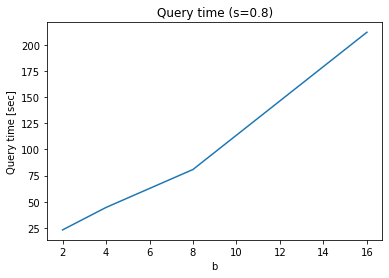

In [270]:
plt.title(f"Query time (s={s})")
plt.xlabel("b")
plt.ylabel("Query time [sec]")
plt.plot(b_list, query_time_list)
plt.show()

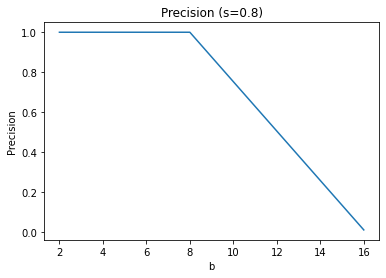

In [271]:
plt.title(f"Precision (s={s})")
plt.xlabel("b")
plt.ylabel("Precision")
plt.plot(b_list, precision_list)
plt.show()

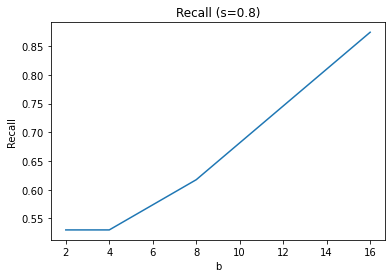

In [272]:
plt.title(f"Recall (s={s})")
plt.xlabel("b")
plt.ylabel("Recall")
plt.plot(b_list, recall_list)
plt.show()

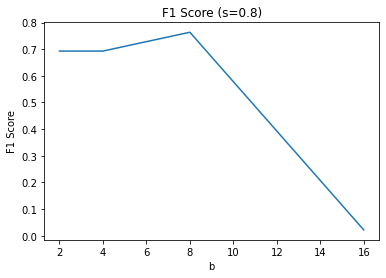

In [273]:
plt.title(f"F1 Score (s={s})")
plt.xlabel("b")
plt.ylabel("F1 Score")
plt.plot(b_list, f1_list)
plt.show()

In [274]:
# Check whether the test passed
test_msg = {True: "Passed", False: "Failed"}

print("-----Test results-----")
print('Test 1:', test_msg[pass_test_1])
print('Test 2:', test_msg[pass_test_2])
print('Test 3:', test_msg[pass_test_3])
print('Test 4:', test_msg[pass_test_4])
print('Test 5:', test_msg[pass_test_5])
print('Test 6:', test_msg[pass_test_6])
print('Test 7:', test_msg[pass_test_7])
print('Test 8:', test_msg[pass_test_8])
print('Test 9:', test_msg[pass_test_9])
print("----------------------")

-----Test results-----
Test 1: Passed
Test 2: Passed
Test 3: Passed
Test 4: Passed
Test 5: Passed
Test 6: Passed
Test 7: Passed
Test 8: Passed
Test 9: Passed
----------------------
